In [1]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
  raw_text = f.read()

print("Total characters", len(raw_text))
raw_text[:99]

Total characters 20479


'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

Each row represents each token

In [ ]:
import torch

inputs = torch.tensor(
  [
    [0.43, 0.15, 0.89], # Your
    [0.55, 0.87, 0.66], # journey
    [0.57, 0.85, 0.64], # starts
    [0.22, 0.58, 0.33], # with
    [0.77, 0.25, 0.10], # one
    [0.05, 0.80, 0.55] #step
  ]
)

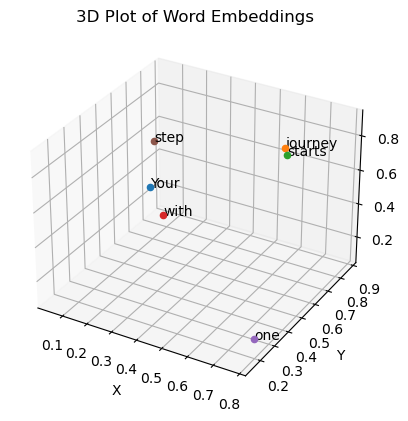

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

x_coords = inputs[:,0].numpy()
y_coords = inputs[:,1].numpy()
z_coords = inputs[:,2].numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
  ax.scatter(x, y, z)
  ax.text(x, y, z, word, fontsize=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

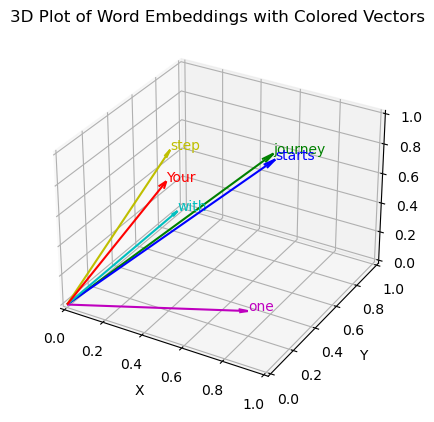

In [5]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

Starts is more important/similar to journey than one is! What mathematical framework can quantify this closeness???

... the dot product! When vectors wre close to each other (not perpendicular), the higher the dot product!

$sim(x,y)\approx x^Ty$ (like in graph ML decoder)

## Some points from lecture (0 - 20 min)

When we factor in $x^{(2)}$ we get a latent vector $z^{(2)}$ which factors in info about this token and __all other tokens__, just after processing this second one.

The attention score exists between each query and input vector.

In [9]:
query = inputs[1] # some vector we want query of

attention_scores = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
  attention_scores[i] = torch.dot(x_i, query)

print(attention_scores)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Journey has the highest attention score (should have highest attention with itself)

But after this, it's "starts." This makes sense given the plot above! The lowest attention score is for "one," ad we can see this is the least similar vector, graphically.

__These attention scores do not sum to 1 and are not interpretable__

We want to normalize because this also helps with stability in training... use softmax (or let's just start with L1)!

In [10]:
attention_scores_l1 = attention_scores / torch.sum(attention_scores)

attention_scores_l1

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])

__Softmax is better! The initial intuition was right.__

Softmax works better because say we have scores

1   2  3  406

The low values should have no weight, but they're slightly positive. This doesn't give good results when back-propagating.

In [19]:
attention_scores_softmax = torch.softmax(attention_scores, dim = 0)

attention_scores_softmax

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

In [16]:
def naive_softmax(tensor):
  return torch.exp(tensor) / torch.exp(tensor).sum(dim=0)

attention_scores_naive_softmax = naive_softmax(attention_scores)
attention_scores_naive_softmax

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])

We just computed the normalized (softmax) attention weights. Now calculate the context vector (i.e. $z^{(2)}$) by multiplying the embedded tokens $x^{(i)}$ witht he corresponding attention weights and summing the resulting vectors.

In [25]:
# This is just a matrix-vector product

context_vector = inputs.T @ attention_scores_softmax
context_vector

tensor([0.4419, 0.6515, 0.5683])

_Now we have to do this for every word._

In [40]:
attention_scores = inputs @ inputs.T
attention_scores

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [44]:
attention_weights = torch.softmax(attention_scores, dim=-1)
attention_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [47]:
torch.sum(attention_weights[0]) # make sure apply softmax in correct dimension

tensor(1.0000)

In [46]:
context_vectors = attention_weights @ inputs
context_vectors

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [49]:
print(f"Previous context vector: {context_vectors[1]}")

Previous context vector: tensor([0.4419, 0.6515, 0.5683])
